# StackPros DS Assessment Project
A mega-online shopping mall provides different baby brands to customers. In order to optimize
online advertisements throughout websites, they want to predict the view-to-click probability given
the information below.
The data consists of:
1. **Action**: the “interaction” that users completed when online ad was exposed. There are
two types of actions in this dataset, **View** (a.k.a Impression) or **Click**.
(Reference: https://en.wikipedia.org/wiki/Impression_(online_media))
2. **ID**: unique user IDs
3. **Action Time**: the time when action (View/Click) happened, in microseconds format
4. **Website**: the website where the ad was published
5. **Banner Size**: the banner size of ad
6. **Brand**: the brand name that the ad was promoting
7. **Colour**: the colour of product showcased in the ad
8. **Interaction Time**: user’s interaction time with each ad (sec)

The problem is essentially a binary classification, and the main objective is to accurately predict the probability of **Click**. The distribution of class in dataset is expected to exhibit highly imbalanced, since most of the click-through rate (CTR) in industry is round 0.2-0.3% for online advertising. In terms of classifier performance metric, the common accuracy metric is no longer valid, as accuracy only reflects the average performance of a classifier. Here, since we only care about whether we can correctly predict an ad will be clicked (positive-class), we could apply receiver operating characteristic (ROC) area-under-curve (AUC) which is class-invariant. In this case, we aim to minimize the probability of an ad that is potentially being miss-classifed to **View** instead of **Click** (i.e., reduce false negative), which in this case the ad publisher will potentially loses business opportunity.

In the following sections, standard ML pipline will be included as:
1. EDA
2. Feature Engineering
3. Feature Selection
4. Baseline Model Selection
5. Hyperparameter Optimization and Model Validation
6. What's Lie Beyond

From section 1 to 5, you will my find analysis and discussion along the way. In the *What's Lie Beyond* section, I include a few additional explorative analysis such as dimension reduction with PCA and feature hashing for **ID**. At last, I have provided some insights and recommendations to this project.

In [1]:
# ML
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE, RFECV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Baseline Models
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import LinearSVC

# Imbalanced ML
from imblearn.ensemble import BalancedBaggingClassifier as BBC
from imblearn.over_sampling import SMOTE

# Utilities
import statsmodels.discrete.discrete_model as sm
import pandas as pd
import numpy as np
from scipy import stats
# Workaround of statsmodels summary() bug
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

import itertools

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = '/resources/data/'
ctr_dir = data_dir + 'StackPros_Assessment_DataScientist_Senior.csv'

In [3]:
df_ctr = pd.read_csv(ctr_dir, index_col=None)
df_ctr.head()

,Unnamed: 0,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime
0,1,AMsySZbNg8SBwPtj7IGHnip_8aY0,1508761859495365,View,Facebook,300x600,Carter's,Pink,0.171601
1,2,AMsySZZcUFNGOJs-lfC9j-ZDlV7Z,1502847469736117,View,Facebook,300x250,Burberry,Red,4.303945
2,3,AMsySZYoK8_bD0hGv4zu0iRn1TFo,1514169431528120,View,Facebook,728x90,Disney,Yellow,0.868106
3,4,AMsySZahxpwLOWnMJj6RGATgwEOc,1515527952591896,View,Facebook,320x50,Carter's,Yellow,0.802647
4,5,AMsySZbqgfMBDtAqZz1jVRaOmX00,1507514809374045,View,instagram.com,300x250,Gap,Gold,0.627148


In [4]:
len(df_ctr.index)

1000000

In [5]:
len(df_ctr[df_ctr['Action'] == 'Click'])

244

We have 1 million observations with only 244 **Click** events, this is worse than I expected... The event rate is only at 0.0244%. Normally for detecting rare event where we have a severe class imbalance, there are three ways to combat it.
1. Undersampling for majority class (e.g., Bootstrapping)
2. Oversampling for minority class (e.g., SMOTE)
3. Hybrid strategy with 1 and 2

However, resampling the data is considered to be last resort when we have a situation that the classifer becomes trival or completely unlearnable under the current class distribution. For now, I will see outcome first then decide if resampling is necessary.

## Explorative Data Analysis
At EDA, we will do some preprocessing and take a dive into each variable to see their impacts on the target. Here, we can first convert **Action** to a binary response.

In [6]:
df_ctr['Action'] = df_ctr['Action'].apply(lambda x: 1 if x == 'Click' else 0)

Here, we found missing value in **InteractionTime** column.

In [7]:
pd.isnull(df_ctr).any(axis=0)

Unnamed: 0         False
ID                 False
ActionTime         False
Action             False
Website            False
BannerSize         False
Brand              False
colour             False
InteractionTime     True
dtype: bool

In [8]:
df_ctr[pd.isnull(df_ctr).any(axis=1)]

,Unnamed: 0,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime
28,29,AMsySZbU2U0u2CDEQPae5UEvj7uh,1513974448167954,0,Facebook,728x90,Gap,Gold,NaN
154,155,AMsySZZNSd4doewEvAFWe9U7SEub,1503968584487308,0,Facebook,320x50,Banana Republic,Gold,NaN
812,813,AMsySZb8b-J-eW7JOEuTeIUQ5qMg,1514261353516880,1,Kijiji,160x600,JoeFresh,other,NaN
98269,98270,AMsySZbCULOmzvMOl_jxgAPZnhmV,1512573518334683,1,Facebook,300x250,Disney,Blue,NaN
243356,243357,AMsySZYtpCq1jCDG6_MR6U9RDbfC,1514698137892676,1,Facebook,160x600,JoeFresh,Pink,NaN
243357,243358,AMsySZa6M_Z79mOnUWF9P8nKac5-,1516738555981098,0,Facebook,300x250,Carter's,Yellow,NaN
331970,331971,AMsySZbyqkZuERDU8VBWoJX_F4tD,1515278217655536,1,Other,1x1,Old Navy,Pink,NaN
451827,451828,AMsySZYZjTd1kTYooOpACb0cTDL2,1515692970262672,1,Facebook,728x90,Old Navy,Pink,NaN


In this case, since there are only 8 samples normally we can simply remove them. However, as noticed among the 8 samples there are 5 **Click** events, and we only have about 244, every useful sample counts! Thus, instead of remove them we can provide some cold-start to the **InteractionTime** using the average of all interaction time.

In [9]:
avg_interact_time = df_ctr['InteractionTime'].mean()
print(avg_interact_time)

0.998667358669745


In [10]:
df_ctr = df_ctr.fillna(avg_interact_time)

In [11]:
pd.isnull(df_ctr).any(axis=0)

Unnamed: 0         False
ID                 False
ActionTime         False
Action             False
Website            False
BannerSize         False
Brand              False
colour             False
InteractionTime    False
dtype: bool

Now, no missing value is found.

In [12]:
print("Number of users:", len(df_ctr['ID'].unique()))
print("Number of websites:", len(df_ctr['Website'].unique()))
print("Number of bannars:", len(df_ctr['BannerSize'].unique()))
print("Number of brands:", len(df_ctr['Brand'].unique()))
print("Number of colours:", len(df_ctr['colour'].unique()))

Number of users: 218686
Number of websites: 16
Number of bannars: 15
Number of brands: 10
Number of colours: 7


All the above columns are categorical variables. Considering we have 1 million observations, the feature space is not that big. However, there are 218686 unique **ID**s, if we use one-hot-encoding for the ID it will present our feature with very high sparsity. This must be handled with care. Because too many features will result poor performance for the classifier, and too sparse the feature we might encouter convergence issue during training.

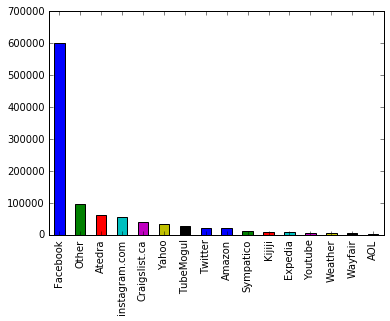

In [13]:
df_ctr['Website'].value_counts().plot(kind='bar')
plt.show()

In [14]:
df_ctr.groupby('Website')['Action'].mean()

Website
AOL              0.000000
Amazon           0.000291
Atedra           0.000032
Craigslist.ca    0.000025
Expedia          0.000858
Facebook         0.000275
Kijiji           0.000906
Other            0.000328
Sympatico        0.000088
TubeMogul        0.000315
Twitter          0.000000
Wayfair          0.000250
Weather          0.000000
Yahoo            0.000178
Youtube          0.000000
instagram.com    0.000143
Name: Action, dtype: float64

We see a lot of variation among all website in terms of clicks, so this could be a good feature.

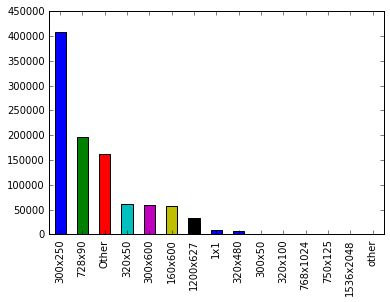

In [15]:
df_ctr['BannerSize'].value_counts().plot(kind='bar')
plt.show()

In [16]:
df_ctr['BannerSize'] = df_ctr['BannerSize'].replace('other', 'Other')

In [17]:
df_ctr.groupby('BannerSize')['Action'].mean()

BannerSize
1200x627     0.000152
1536x2048    0.000000
160x600      0.000625
1x1          0.001848
300x250      0.000196
300x50       0.002195
300x600      0.000186
320x100      0.000000
320x480      0.000000
320x50       0.000193
728x90       0.000245
750x125      0.001748
768x1024     0.000000
Other        0.000191
Name: Action, dtype: float64

Similar as website, we can see variations among all banner sizes, so this could be a good feature too. Because the banner size draw visual attention to users, intuitively it must be an important feature.

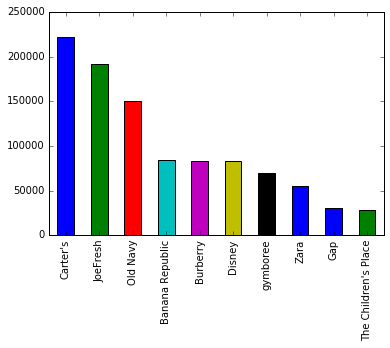

In [18]:
df_ctr['Brand'].value_counts().plot(kind='bar')
plt.show()

In [19]:
df_ctr.groupby('Brand')['Action'].mean()

Brand
Banana Republic         0.000143
Burberry                0.000252
Carter's                0.000265
Disney                  0.000156
Gap                     0.000358
JoeFresh                0.000219
Old Navy                0.000259
The Children's Place    0.000286
Zara                    0.000288
gymboree                0.000328
Name: Action, dtype: float64

As seen, all brands have very similar average click counts, so the 'Brand' might be a bad feature to use for classification. We can potentially disregard it in feature selection.

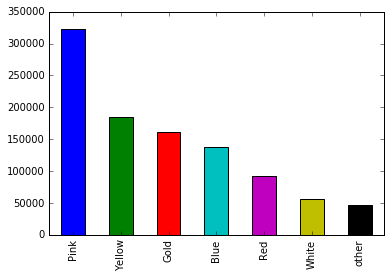

In [20]:
df_ctr['colour'].value_counts().plot(kind='bar')
plt.show()

In [21]:
df_ctr.groupby('colour')['Action'].mean()

colour
Blue      0.000232
Gold      0.000248
Pink      0.000245
Red       0.000238
White     0.000180
Yellow    0.000261
other     0.000283
Name: Action, dtype: float64

For among all the colours the click rates are quite similar (relatively low variance) which makes it a less desirable feature to differentiate the two classes, so we can potentially disregard it in feature selection.

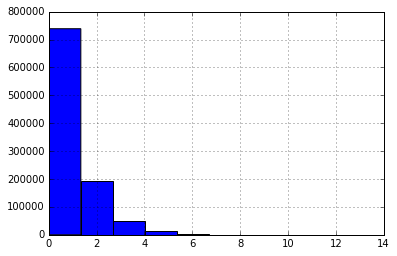

In [44]:
df_ctr['InteractionTime'].hist()
plt.show()

We see most of the interation times are within 1 second, the distribution is heavily right-skewed.

In [23]:
df_ctr.groupby('Action')['InteractionTime'].mean()

Action
0    0.998662
1    1.021115
Name: InteractionTime, dtype: float64

For both **View** and **Click**, average interation times are very very close, thus this could not be well contributed to classification as the colours. But we will keep it for now.

In [24]:
np.count_nonzero(df_ctr.groupby('ID')['Action'].sum() > 0)

211

There are almost 218,686 unique users but only 211 user have clicked an ad before. The user click rate is less than 0.1%. However, the user information might be useful because it introduces a click-prior for each user. For example, a user who has clicked an ad before is more likely to click a new ad than a user who has never clicked before (e.g., a new user), and a user who clicked more before is rather likely to click more than a user who only clicked once. At the moment I temporarily hold out this user-dependent feature aside from the main analysis and come back later if I have time (see What's Lie Beyond).

To properly process ID information as feature, we firstly need to apply feature hashing for the user ID due to its large feature space, 218,686 to be excatly. If we opt to one-hot-encoding (OHE), the linear model might be hurt by high sparsity inputs. We can hash map the ID to a fixed-length vector-space that could be siginificantly shorter than OHE to mitigate high sparsity.

## Feature Engineering
The main feature we are going to re-engineer is the temporal-dependent information, which is our **ActionTime** here. The **ActionTime** displays the timestamps of each action taken place that can potential lead to more behavior information we can exploit.

First, we convert **ActionTime** (in microsecond) to DateTime object.

In [26]:
df_ctr['DateTime'] = pd.to_datetime(df_ctr['ActionTime'], unit='us')
df_ctr.head()

,Unnamed: 0,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime,DateTime
0,1,AMsySZbNg8SBwPtj7IGHnip_8aY0,1508761859495365,0,Facebook,300x600,Carter's,Pink,0.171601,2017-10-23 12:30:59.495365
1,2,AMsySZZcUFNGOJs-lfC9j-ZDlV7Z,1502847469736117,0,Facebook,300x250,Burberry,Red,4.303945,2017-08-16 01:37:49.736117
2,3,AMsySZYoK8_bD0hGv4zu0iRn1TFo,1514169431528120,0,Facebook,728x90,Disney,Yellow,0.868106,2017-12-25 02:37:11.528120
3,4,AMsySZahxpwLOWnMJj6RGATgwEOc,1515527952591896,0,Facebook,320x50,Carter's,Yellow,0.802647,2018-01-09 19:59:12.591896
4,5,AMsySZbqgfMBDtAqZz1jVRaOmX00,1507514809374045,0,instagram.com,300x250,Gap,Gold,0.627148,2017-10-09 02:06:49.374045


Then add extra columns for years and months.

In [27]:
df_ctr['Year'] = df_ctr['DateTime'].dt.year
df_ctr['Month'] = df_ctr['DateTime'].dt.month

And we convert day to the day of a week, i.e., Monday, Tuesday, .... This essentially we bin the 30-day of a month into 7 categories. This is because firstly 30 categories for day is too many, and we assume that user behavior is more relevant or dependent on the day of a week and there is no distinguished significance to e.g., on 15th and 16th of a month.

In [28]:
df_ctr['DayWeek'] = df_ctr['DateTime'].dt.weekday_name

Similarly for the hour of a day, at 1pm and 2pm we assume no user behavior change. Then, we bin hours into the periods of a day as Morning, Afternoon, Evening, Night.

In [29]:
day_period_bins = [0, 5, 13, 17, 25]
labels = ['Morning', 'Afternoon', 'Evening', 'Night']
hours = df_ctr['DateTime'].dt.hour
df_ctr['DayPeriod'] = pd.cut(hours - 5 + 24 * (hours < 5),
                             bins=day_period_bins,
                             labels=labels,
                             right=False)  

In addition, we can also convert to day of week into whether it's a weekend or not, because user behavior is expected to be significantly change during weekends. Note: days of a week and weekend has correlation between each others, we probably have to choose one of them in order to avoid multicollinearity.

Binary response for weekend flag

In [30]:
df_ctr['Weekend'] = df_ctr['DayWeek'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

In [31]:
df_ctr.head()

,Unnamed: 0,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime,DateTime,Year,Month,DayWeek,DayPeriod,Weekend
0,1,AMsySZbNg8SBwPtj7IGHnip_8aY0,1508761859495365,0,Facebook,300x600,Carter's,Pink,0.171601,2017-10-23 12:30:59.495365,2017,10,Monday,Afternoon,0
1,2,AMsySZZcUFNGOJs-lfC9j-ZDlV7Z,1502847469736117,0,Facebook,300x250,Burberry,Red,4.303945,2017-08-16 01:37:49.736117,2017,8,Wednesday,Night,0
2,3,AMsySZYoK8_bD0hGv4zu0iRn1TFo,1514169431528120,0,Facebook,728x90,Disney,Yellow,0.868106,2017-12-25 02:37:11.528120,2017,12,Monday,Night,0
3,4,AMsySZahxpwLOWnMJj6RGATgwEOc,1515527952591896,0,Facebook,320x50,Carter's,Yellow,0.802647,2018-01-09 19:59:12.591896,2018,1,Tuesday,Evening,0
4,5,AMsySZbqgfMBDtAqZz1jVRaOmX00,1507514809374045,0,instagram.com,300x250,Gap,Gold,0.627148,2017-10-09 02:06:49.374045,2017,10,Monday,Night,0


Seems like we only have 2017 and 2018 in year column, we can convert it to binary as well.

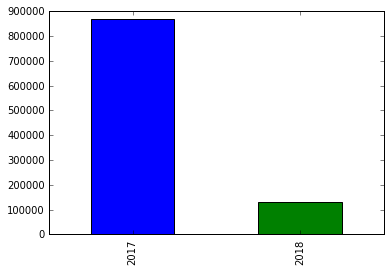

In [32]:
df_ctr['Year'].value_counts().plot(kind='bar')
plt.show()

In [33]:
df_ctr.groupby('Year').mean()['Action']

Year
2017    0.000211
2018    0.000465
Name: Action, dtype: float64

In [34]:
df_ctr['Year'] = df_ctr['Year'].apply(lambda x: 1 if x == 2018 else 0)

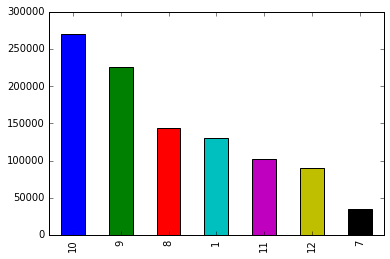

In [35]:
df_ctr['Month'].value_counts().plot(kind='bar')
plt.show()

In [36]:
df_ctr.groupby('Month')['Action'].mean()

Month
1     0.000465
7     0.000141
8     0.000159
9     0.000097
10    0.000152
11    0.000380
12    0.000588
Name: Action, dtype: float64

We can see significant difference for click in the **Month**, as people tend to shop during holiday such as Thanksgiving, Xmas and New Year, which are Nov, Dec and Jan. 

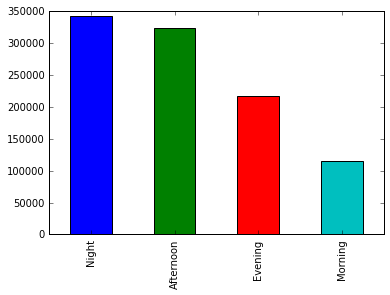

In [37]:
df_ctr['DayPeriod'].value_counts().plot(kind='bar')
plt.show()

In [38]:
df_ctr.groupby('DayPeriod')['Action'].mean()

DayPeriod
Morning      0.000147
Afternoon    0.000284
Evening      0.000345
Night        0.000175
Name: Action, dtype: float64

We see some variantions in period of day, which can be a good feature. People tend to shop more in afternoon and evenning, like maybe after lunch and dinner... This correlates very well with user behavior.

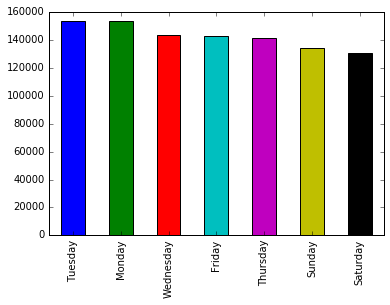

In [39]:
df_ctr['DayWeek'].value_counts().plot(kind='bar')
plt.show()

In [40]:
df_ctr.groupby('DayWeek')['Action'].mean()

DayWeek
Friday       0.000301
Monday       0.000281
Saturday     0.000191
Sunday       0.000097
Thursday     0.000268
Tuesday      0.000339
Wednesday    0.000208
Name: Action, dtype: float64

The day of week does show some variations in clicks, but not too significant.

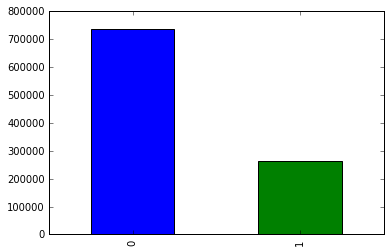

In [41]:
df_ctr['Weekend'].value_counts().plot(kind='bar')
plt.show()

In [42]:
df_ctr.groupby('Weekend')['Action'].mean()

Weekend
0    0.000280
1    0.000143
Name: Action, dtype: float64

**Weekend** seems to be a good feature, and it correlates well to human behavior. People tend to shop more during weekends.

Convert categorical data to one-hot-encoding

In [43]:
# Ad-dependent
df_ctr['Website'] = df_ctr['Website'].astype('category')
df_ctr['BannerSize'] = df_ctr['BannerSize'].astype('category')
df_ctr['Brand'] = df_ctr['Brand'].astype('category')
df_ctr['colour'] = df_ctr['colour'].astype('category')

# Temporal-dependent
df_ctr['DayPeriod'] = df_ctr['DayPeriod'].astype('category')
df_ctr['DayWeek'] = df_ctr['DayWeek'].astype('category')
df_ctr['Month'] = df_ctr['Month'].astype('category')

In [44]:
df_ctr.head()

,Unnamed: 0,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime,DateTime,Year,Month,DayWeek,DayPeriod,Weekend
0,1,AMsySZbNg8SBwPtj7IGHnip_8aY0,1508761859495365,0,Facebook,300x600,Carter's,Pink,0.171601,2017-10-23 12:30:59.495365,0,10,Monday,Afternoon,0
1,2,AMsySZZcUFNGOJs-lfC9j-ZDlV7Z,1502847469736117,0,Facebook,300x250,Burberry,Red,4.303945,2017-08-16 01:37:49.736117,0,8,Wednesday,Night,0
2,3,AMsySZYoK8_bD0hGv4zu0iRn1TFo,1514169431528120,0,Facebook,728x90,Disney,Yellow,0.868106,2017-12-25 02:37:11.528120,0,12,Monday,Night,0
3,4,AMsySZahxpwLOWnMJj6RGATgwEOc,1515527952591896,0,Facebook,320x50,Carter's,Yellow,0.802647,2018-01-09 19:59:12.591896,1,1,Tuesday,Evening,0
4,5,AMsySZbqgfMBDtAqZz1jVRaOmX00,1507514809374045,0,instagram.com,300x250,Gap,Gold,0.627148,2017-10-09 02:06:49.374045,0,10,Monday,Night,0


In [45]:
# Ad-dependent
dummy_website = pd.get_dummies(df_ctr['Website'], prefix='Website')
dummy_banner = pd.get_dummies(df_ctr['BannerSize'], prefix='BannerSize')
dummy_brand = pd.get_dummies(df_ctr['Brand'], prefix='Brand')
dummy_colour = pd.get_dummies(df_ctr['colour'], prefix='colour')

# Temporal-dependent
dummy_dayperid = pd.get_dummies(df_ctr['DayPeriod'], prefix='DayPeriod')
dummy_dayweek = pd.get_dummies(df_ctr['DayWeek'], prefix='DayWeek')
dummy_month = pd.get_dummies(df_ctr['Month'], prefix='Month')

From the above preliminary analysis on all the features, I decide to drop **color** that has low variation between target response, and user **Weekend** instead of **DayWeek** that has more difference in terms of average clicks also to avoid potential collinearity.

In [46]:
col_keep = ['InteractionTime', 'Year', 'Weekend']
df_data = pd.concat([df_ctr[col_keep],
                     dummy_website,
                     dummy_banner,
                     dummy_brand,
                     dummy_dayperid,
                     dummy_month], axis=1)

columns = df_data.columns.tolist()

In [47]:
df_data.head()

,InteractionTime,Year,Weekend,Website_AOL,Website_Amazon,Website_Atedra,Website_Craigslist.ca,Website_Expedia,Website_Facebook,Website_Kijiji,...,DayPeriod_Afternoon,DayPeriod_Evening,DayPeriod_Night,Month_1,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,0.171601,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
1,4.303945,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
2,0.868106,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
3,0.802647,1,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
4,0.627148,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


## Feature Selection

Now we do feature selection in a systematic approach. The following sections contain univariate analysis (Chi-squared test), multivariate regression analysis with *statsmodels*'s Logistic Regression and Recursive Feature Elimination (multivariate).

### Univariate Analysis
As most of our variables are categorical, Chi-squaref test could be a desirable hypothesis testing to evaluate the impact or significance between our feature variables and target.

In [50]:
selector_chi2 = SelectKBest(chi2, 'all')
selector_chi2.fit(df_data, df_ctr['Action'])
pp = selector_chi2.pvalues_

In [51]:
chi2_ranked_feats = sorted(zip(pp, columns))
chi2_ranked_feats

[(1.2166203550106162e-21, 'BannerSize_1x1'),
 (3.86337770609294e-11, 'Month_12'),
 (4.644557833630922e-09, 'BannerSize_160x600'),
 (9.657270400008302e-08, 'BannerSize_300x50'),
 (2.8790587416898255e-07, 'Month_1'),
 (2.8790587416898255e-07, 'Year'),
 (8.159913484964679e-06, 'Month_9'),
 (0.0001947325123924221, 'Website_Kijiji'),
 (0.0007716742310683848, 'Website_Atedra'),
 (0.0009229774615929495, 'Weekend'),
 (0.0010094867206909804, 'Website_Expedia'),
 (0.002102356309380668, 'Month_10'),
 (0.00250924092873302, 'DayPeriod_Evening'),
 (0.005183400615976847, 'Month_11'),
 (0.00526626472214336, 'Website_Craigslist.ca'),
 (0.009510257383632365, 'DayPeriod_Night'),
 (0.021254185132787772, 'BannerSize_750x125'),
 (0.023296770739114254, 'Website_Twitter'),
 (0.0339675124172317, 'DayPeriod_Morning'),
 (0.039121615435606, 'Month_8'),
 (0.04822613230124487, 'BannerSize_300x250'),
 (0.059889673159506024, 'Brand_Banana Republic'),
 (0.09361207719741792, 'Website_Other'),
 (0.10506297660216293, 'Br

In [52]:
np.count_nonzero(pp < 0.05)

21

We found that there are only 21 features that are considered as useful (or statisitical significant) for the target (p-value < 0.05).

In [53]:
top_chi2_feats = [feat for _, feat in chi2_ranked_feats[:21]]
top_chi2_feats

['BannerSize_1x1',
 'Month_12',
 'BannerSize_160x600',
 'BannerSize_300x50',
 'Month_1',
 'Year',
 'Month_9',
 'Website_Kijiji',
 'Website_Atedra',
 'Weekend',
 'Website_Expedia',
 'Month_10',
 'DayPeriod_Evening',
 'Month_11',
 'Website_Craigslist.ca',
 'DayPeriod_Night',
 'BannerSize_750x125',
 'Website_Twitter',
 'DayPeriod_Morning',
 'Month_8',
 'BannerSize_300x250']

### Regression Analysis (Multivariate)
After obtaining the top features based on univariate analysis, it is essential to see how those features perform together. The logistic regression analysis is also a good starting point to do multvariate analysis, since our dependent variabels are categorical by most and we have a binary response in target. Here we only performs the regression analysis with the top 21 features yield from chi-squared test.

In [54]:
df_top_chi2 = df_data[top_chi2_feats]

In [55]:
df_top_chi2['Intercept'] = 1
df_top_chi2.head()

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,BannerSize_1x1,Month_12,BannerSize_160x600,BannerSize_300x50,Month_1,Year,Month_9,Website_Kijiji,Website_Atedra,Weekend,...,DayPeriod_Evening,Month_11,Website_Craigslist.ca,DayPeriod_Night,BannerSize_750x125,Website_Twitter,DayPeriod_Morning,Month_8,BannerSize_300x250,Intercept
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1


In [117]:
res_lr_chi2 = sm.Logit(df_ctr['Action'], df_top_chi2).fit(method='bfgs', maxiter=100)

Optimization terminated successfully.
         Current function value: 0.002174
         Iterations: 71
         Function evaluations: 72
         Gradient evaluations: 72


/resources/common/.virtualenv/python3/lib/python3.5/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


From what it seems like statsmodels logitic regression is a bit sensitive to a highly sparse input. In our data, there are some columns containing all-zeros (e.g., Twitter, AOL, Weather, some BannerSizes with zero count in **Click**) which may cause problem when calculating Hessian matrix.

In [ ]:
res_lr_chi2.summary()

### Recursive Feature Elimination
With the failure of LR multivariate analysis, I opt to use recursive feature elimination (RFE). The goal of RFE is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through the coefficients of a linear model. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached (http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html).

In [57]:
rfe = RFE(estimator=LR(class_weight='balanced'), n_features_to_select=1, step=1)
selector_rfe = rfe.fit(df_data, df_ctr['Action'])

In [64]:
selector_rfe.ranking_

array([54, 41, 26,  6, 14, 48, 29, 12, 15, 11, 17, 27, 13,  1, 16,  3, 18,
        2, 19, 47,  7, 21,  9, 34,  8, 33,  5,  4, 35, 32, 10, 46, 36, 31,
       49, 52, 30, 40, 45, 50, 53, 44, 39, 25, 43, 51, 28, 38, 24, 23, 20,
       22, 42, 37])

In [92]:
rfe_ranked_feats = sorted(zip(selector_rfe.ranking_, columns))
rfe_ranked_feats

[(1, 'Website_Twitter'),
 (2, 'Website_Youtube'),
 (3, 'Website_Weather'),
 (4, 'BannerSize_320x480'),
 (5, 'BannerSize_320x100'),
 (6, 'Website_AOL'),
 (7, 'BannerSize_1536x2048'),
 (8, 'BannerSize_300x50'),
 (9, 'BannerSize_1x1'),
 (10, 'BannerSize_750x125'),
 (11, 'Website_Kijiji'),
 (12, 'Website_Expedia'),
 (13, 'Website_TubeMogul'),
 (14, 'Website_Amazon'),
 (15, 'Website_Facebook'),
 (16, 'Website_Wayfair'),
 (17, 'Website_Other'),
 (18, 'Website_Yahoo'),
 (19, 'Website_instagram.com'),
 (20, 'Month_9'),
 (21, 'BannerSize_160x600'),
 (22, 'Month_10'),
 (23, 'Month_8'),
 (24, 'Month_7'),
 (25, 'DayPeriod_Morning'),
 (26, 'Weekend'),
 (27, 'Website_Sympatico'),
 (28, 'DayPeriod_Night'),
 (29, 'Website_Craigslist.ca'),
 (30, 'Brand_Disney'),
 (31, 'Brand_Banana Republic'),
 (32, 'BannerSize_728x90'),
 (33, 'BannerSize_300x600'),
 (34, 'BannerSize_300x250'),
 (35, 'BannerSize_320x50'),
 (36, 'BannerSize_Other'),
 (37, 'Month_12'),
 (38, 'Month_1'),
 (39, 'Brand_gymboree'),
 (40, 'Br

In [48]:
# This is just reminder of the Ranked RFE features so I don't have to re-run it again
rfe_ranked_feats = [(1, 'Website_Twitter'),
 (2, 'Website_Youtube'),
 (3, 'Website_Weather'),
 (4, 'BannerSize_320x480'),
 (5, 'BannerSize_320x100'),
 (6, 'Website_AOL'),
 (7, 'BannerSize_1536x2048'),
 (8, 'BannerSize_300x50'),
 (9, 'BannerSize_1x1'),
 (10, 'BannerSize_750x125'),
 (11, 'Website_Kijiji'),
 (12, 'Website_Expedia'),
 (13, 'Website_TubeMogul'),
 (14, 'Website_Amazon'),
 (15, 'Website_Facebook'),
 (16, 'Website_Wayfair'),
 (17, 'Website_Other'),
 (18, 'Website_Yahoo'),
 (19, 'Website_instagram.com'),
 (20, 'Month_9'),
 (21, 'BannerSize_160x600'),
 (22, 'Month_10'),
 (23, 'Month_8'),
 (24, 'Month_7'),
 (25, 'DayPeriod_Morning'),
 (26, 'Weekend'),
 (27, 'Website_Sympatico'),
 (28, 'DayPeriod_Night'),
 (29, 'Website_Craigslist.ca'),
 (30, 'Brand_Disney'),
 (31, 'Brand_Banana Republic'),
 (32, 'BannerSize_728x90'),
 (33, 'BannerSize_300x600'),
 (34, 'BannerSize_300x250'),
 (35, 'BannerSize_320x50'),
 (36, 'BannerSize_Other'),
 (37, 'Month_12'),
 (38, 'Month_1'),
 (39, 'Brand_gymboree'),
 (40, 'Brand_Gap'),
 (41, 'Year'),
 (42, 'Month_11'),
 (43, 'DayPeriod_Afternoon'),
 (44, 'Brand_Zara'),
 (45, 'Brand_JoeFresh'),
 (46, 'BannerSize_768x1024'),
 (47, 'BannerSize_1200x627'),
 (48, 'Website_Atedra'),
 (49, 'Brand_Burberry'),
 (50, 'Brand_Old Navy'),
 (51, 'DayPeriod_Evening'),
 (52, "Brand_Carter's"),
 (53, "Brand_The Children's Place"),
 (54, 'InteractionTime')]

In [49]:
rfe_feats = [col for i, col in rfe_ranked_feats]

Now that we have ranked all of our features, we have to choose the top number of features that to be the most representive. One way we can do is to test out our model using various portions of features. As we have only 54 features, this can be similarly implemented as RFE, that we recursively remove the least ranked feature at a time down to one feature to find the best performing model.

In [53]:
def select_top_features(estimator, X, y):
    """
    Try to find the top RFE ranked features by recursively eliminating
    the lowest ranked features in every iteration. Scoring method: ROC-AUC.
    
    Args:
        estimator (object): Classifier
        X (NumPy array): Inputs
        y (NumPy array): Targets
    
    Returns:
        top_feats (list): Top feature names
        scores (list): AUC Scores

    """
    # Get all feature names
    columns = X.columns.tolist()
    feats = columns[:]
    # Split into train/dev sets
    X_train, X_dev, y_train, y_dev = train_test_split(X, y,
                                                      test_size=0.1,
                                                      random_state=13)
    scores = []
    while len(feats) > 1:
        print("Train using {} features.".format(len(feats)))
        X_feats = X_train[feats]
        estimator.fit(X_feats, y_train)
        # y_pred = estimator.predict(X_test)
        y_pred_prob = estimator.predict_proba(X_dev[feats])
        
        scores.append(roc_auc_score(y_dev, y_pred_prob[:, 1]))
        feats.pop()
    
    # Find the best cutoff point
    best_cutoff = np.argsort(scores)[-1]
    # Top k is at the cutoff, e.g., if 54 in total and cutoff is at 2,
    # then the top features are the first 52 out of 54
    topk = len(feats) - best_cutoff
    top_feats = columns[:topk]
    
    return top_feats, scores

In [103]:
top_rfe_feats, auc_scores = select_top_features(LR(class_weight='balanced'),
                                                df_data[rfe_feats].as_matrix(),
                                                df_ctr['Action'].as_matrix())

Train using 54 features.
Train using 53 features.
Train using 52 features.
Train using 51 features.
Train using 50 features.
Train using 49 features.
Train using 48 features.
Train using 47 features.
Train using 46 features.
Train using 45 features.
Train using 44 features.
Train using 43 features.
Train using 42 features.
Train using 41 features.
Train using 40 features.
Train using 39 features.
Train using 38 features.
Train using 37 features.
Train using 36 features.
Train using 35 features.
Train using 34 features.
Train using 33 features.
Train using 32 features.
Train using 31 features.
Train using 30 features.
Train using 29 features.
Train using 28 features.
Train using 27 features.
Train using 26 features.
Train using 25 features.
Train using 24 features.
Train using 23 features.
Train using 22 features.
Train using 21 features.
Train using 20 features.
Train using 19 features.
Train using 18 features.
Train using 17 features.
Train using 16 features.
Train using 15 features.


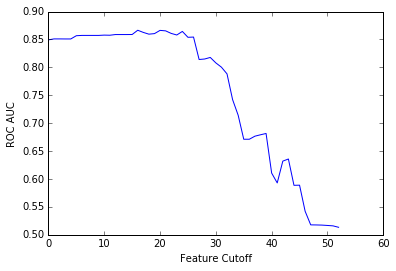

In [109]:
plt.plot(auc_scores)
plt.xlabel("Feature Cutoff")
plt.ylabel("ROC AUC")
plt.show()

As observed, the cutoff point is at round 20-ish where the model performs the best. To be exact, the best cutoff is 16 which means the first 54-16=38 features performs the best, and the following are names of the top RFE features.

In [110]:
top_rfe_feats

['Website_Twitter',
 'Website_Youtube',
 'Website_Weather',
 'BannerSize_320x480',
 'BannerSize_320x100',
 'Website_AOL',
 'BannerSize_1536x2048',
 'BannerSize_300x50',
 'BannerSize_1x1',
 'BannerSize_750x125',
 'Website_Kijiji',
 'Website_Expedia',
 'Website_TubeMogul',
 'Website_Amazon',
 'Website_Facebook',
 'Website_Wayfair',
 'Website_Other',
 'Website_Yahoo',
 'Website_instagram.com',
 'Month_9',
 'BannerSize_160x600',
 'Month_10',
 'Month_8',
 'Month_7',
 'DayPeriod_Morning',
 'Weekend',
 'Website_Sympatico',
 'DayPeriod_Night',
 'Website_Craigslist.ca',
 'Brand_Disney',
 'Brand_Banana Republic',
 'BannerSize_728x90',
 'BannerSize_300x600',
 'BannerSize_300x250',
 'BannerSize_320x50',
 'BannerSize_Other',
 'Month_12',
 'Month_1',
 'Brand_gymboree']

In [50]:
# This is just reminder of the top RFE features so I don't have to re-run it again
top_rfe_feats = ['Website_Twitter',
 'Website_Youtube',
 'Website_Weather',
 'BannerSize_320x480',
 'BannerSize_320x100',
 'Website_AOL',
 'BannerSize_1536x2048',
 'BannerSize_300x50',
 'BannerSize_1x1',
 'BannerSize_750x125',
 'Website_Kijiji',
 'Website_Expedia',
 'Website_TubeMogul',
 'Website_Amazon',
 'Website_Facebook',
 'Website_Wayfair',
 'Website_Other',
 'Website_Yahoo',
 'Website_instagram.com',
 'Month_9',
 'BannerSize_160x600',
 'Month_10',
 'Month_8',
 'Month_7',
 'DayPeriod_Morning',
 'Weekend',
 'Website_Sympatico',
 'DayPeriod_Night',
 'Website_Craigslist.ca',
 'Brand_Disney',
 'Brand_Banana Republic',
 'BannerSize_728x90',
 'BannerSize_300x600',
 'BannerSize_300x250',
 'BannerSize_320x50',
 'BannerSize_Other',
 'Month_12',
 'Month_1',
 'Brand_gymboree']

## Baseline Model Selection

In [51]:
df_data_top = df_data[top_rfe_feats]
df_data_top.head()

,Website_Twitter,Website_Youtube,Website_Weather,BannerSize_320x480,BannerSize_320x100,Website_AOL,BannerSize_1536x2048,BannerSize_300x50,BannerSize_1x1,BannerSize_750x125,...,Brand_Disney,Brand_Banana Republic,BannerSize_728x90,BannerSize_300x600,BannerSize_300x250,BannerSize_320x50,BannerSize_Other,Month_12,Month_1,Brand_gymboree
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [52]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [53]:
X_data, y_data = df_data_top.as_matrix(), df_ctr['Action'].as_matrix()

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size=0.1,
                                                    random_state=13)

In [88]:
print("Class ratio (View/Click): {}/{} in train data.".format(len(y_train)-y_train.sum(), y_train.sum()))
print("Class ratio (View/Click): {}/{} in test data.".format(len(y_test)-y_test.sum(), y_test.sum()))

Class ratio (View/Click): 899789/211 in train data.
Class ratio (View/Click): 99967/33 in test data.


### Sneak Peek
Let's just take a look at how LR performs on the test set to decide if it'a valid choice to proceed

In [133]:
estimator = LR(class_weight='balanced')
estimator.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [134]:
y_pred = estimator.predict(X_test)
y_pred_prob = estimator.predict_proba(X_test)

Confusion matrix, without normalization


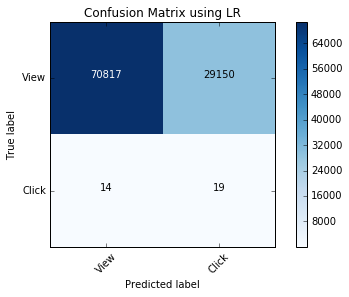

In [135]:
cm_lr = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm_lr, classes=['View', 'Click'],
                      title='Confusion Matrix using LR')
plt.show()

In [136]:
roc_auc_score(y_test, y_pred_prob[:, 1])

0.729551661139085

What it seems ROC-AUC of LR on the test is just OK (about 0.73), we correctly predict 19 out of 33 clicks in the test set. From the confusion matrix, we can see there are a lot of false positive cases where the classifier miss-label the **View**s to **Click**s. In some sense, it is fine because if an Ad that will not be clicked but still being published will not hurt the ad publisher, but on the other side if an Ad that will be clicked but not published that will cause publisher to lose business opportunity. Therefore, we are paying more attention to the positive-class **Click**.

### Baseline Models
In this section, we are going to select the best classifer from a list of baseline candidates. Candidate list: Logistic Regression, Random Forest, Gradient Boosting and Balanced Bagging. Thanks to the imblearn Team, to deal with imbalance problem in our dataset, we can try out the Balanced Bagging classifier, a extended version of sklearn' bagging classifier that includes an additional step to balance the training step at fit time (http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.ensemble.BalancedBaggingClassifier.html).

To properly select the model, we will use 10-fold cross-validation. On each training iteration, we train all baselines with the 9-folds and record an AUC score on the remaining one fold (dev set). Hence, we will have overall baselines' performances on all 10 folds.

In [137]:
baselines = [('Logistic Regression', LR(class_weight='balanced')),
             ('Random Forest', RFC(max_depth=5, class_weight='balanced')),
             ('Gradient Boosting', GBC()),
             ('Balanced Bagging', BBC())]

In [58]:
def cv_select_model(classifiers, X, y, n_splits=5, shuffle=True, oversample=False):
    """
    Use cross-validation to select the best models based on ROC-AUC metric
    
    Args:
        classifiers (list): A list of classifiers
        X (NumPy array): Inputs
        y (NumPy array): Targets
        n_splits (int): Number of CV folds
        shuffle (bool): Shuffle flag
        oversample (bool): Oversample flag

    Returns:
        cv_auc_scores (list): CV AUC scores

    """
    cv_auc_scores = []
    cv = KFold(n_splits=n_splits, shuffle=shuffle)
    smote = SMOTE(ratio=0.001, random_state=13) if oversample else None
    
    for fold, (train_index, dev_index) in enumerate(cv.split(X)):
        print("Fold:", fold + 1)
        X_train, X_dev = X[train_index], X[dev_index]
        y_train, y_dev = y[train_index], y[dev_index]
        
        if oversample:
            X_train, y_train = smote.fit_sample(X_train, y_train)
            # Round floats to categorical data
            X_train = np.round(X_train) 
        
        auc_scores = []
        for name, clf in classifiers:
            print("Training: ", name)
            clf.fit(X_train, y_train)
#             y_pred = clf.predict(X_dev)
            y_pred_prob = clf.predict_proba(X_dev)
            auc_scores.append(roc_auc_score(y_dev, y_pred_prob[:, 1]))
        
        cv_auc_scores.append(auc_scores)

    return cv_auc_scores

In [59]:
cv_auc_scores = cv_select_model(baselines, X_data, y_data, n_splits=10)

Fold: 1
Training:  Logistic Regression
Training:  Random Forest
Training:  Gradient Boosting
Training:  Balanced Bagging
Fold: 2
Training:  Logistic Regression
Training:  Random Forest
Training:  Gradient Boosting
Training:  Balanced Bagging
Fold: 3
Training:  Logistic Regression
Training:  Random Forest
Training:  Gradient Boosting
Training:  Balanced Bagging
Fold: 4
Training:  Logistic Regression
Training:  Random Forest
Training:  Gradient Boosting
Training:  Balanced Bagging
Fold: 5
Training:  Logistic Regression
Training:  Random Forest
Training:  Gradient Boosting
Training:  Balanced Bagging
Fold: 6
Training:  Logistic Regression
Training:  Random Forest
Training:  Gradient Boosting
Training:  Balanced Bagging
Fold: 7
Training:  Logistic Regression
Training:  Random Forest
Training:  Gradient Boosting
Training:  Balanced Bagging
Fold: 8
Training:  Logistic Regression
Training:  Random Forest
Training:  Gradient Boosting
Training:  Balanced Bagging
Fold: 9
Training:  Logistic Regr

In [60]:
cv_auc_scores = np.array(cv_auc_scores)
cv_auc_scores

array([[0.71723419, 0.68934651, 0.70578406, 0.70268159],
       [0.80849006, 0.78072898, 0.79229797, 0.79425046],
       [0.68299097, 0.64633933, 0.70203255, 0.61918142],
       [0.67979821, 0.71484413, 0.73779771, 0.71092765],
       [0.76216576, 0.71337186, 0.77432735, 0.71339437],
       [0.73114568, 0.73529898, 0.74965947, 0.69048019],
       [0.66510613, 0.65511641, 0.65457991, 0.54527423],
       [0.7830332 , 0.7139025 , 0.77795381, 0.73630182],
       [0.72167046, 0.72094426, 0.73421973, 0.73865896],
       [0.72057394, 0.68110453, 0.65071564, 0.6254444 ]])

Here each column represents a model's performance on all 10 folds.

In [61]:
clf_dev_auc_mean = np.mean(cv_auc_scores, axis=0)
clf_dev_auc_std = np.std(cv_auc_scores, axis=0)

In [62]:
for i, (m, s) in enumerate(zip(clf_dev_auc_mean, clf_dev_auc_std)):
    print("{} ROC-AUC mean/std:\t{:.4f}/{:.4f}".format(baselines[i][0], m, s))

Logistic Regression ROC-AUC mean/std:	0.7272/0.0438
Random Forest ROC-AUC mean/std:	0.7051/0.0373
Gradient Boosting ROC-AUC mean/std:	0.7279/0.0468
Balanced Bagging ROC-AUC mean/std:	0.6877/0.0683


We can see on average GB (about tie with LR) outperforms the rest of candidates, but we still need to test its significance. Below, I choose GB's scores to test with the rest.

In [66]:
top_auc_scores = cv_auc_scores[:, 2]
indices = [0, 1, 3]
pps = [stats.ttest_rel(top_auc_scores, cv_auc_scores[:, i])[1] for i in indices]
pps

[0.9467438341839594, 0.037913330136461455, 0.00839009000300381]

As seen from the three p-values tested using t-test of GB to other three candidates (LR, RF, BB), the results are statisitcally significant to Random Forest and Balanced Bagging (p-values < 0.05). Here GB and LR both show highly competitive performance, drawing a tie, but I decide to choose LR, as its variance is smaller meaning it is likely to be more consistent and also for its speed and simplicity which makes hyperparameter optimization easier (GB has too many variables to tune).

## Hyperparameter Optimization and Model Validation (Nested Cross Validation)
Now that we have choose LR, hyperparameter tunning is just a piece of cake. For LR, there is one parameter you can tune which is the inverse regularization strength *C*. Here we can just use a grid search to exhausitively find the best performing LR with regularization.

Here, nested cross-validation (CV) is implemented to perform model validation in which hyperparameters needed to be optimized. The main purpose of nested CV is to prevent information "leakage" into the model and overfit the data. In nested CV we have 2 loops of CV, the inner loop is to find the best hyperparameter using grid search, then we use this model to evaluate the generalization error in the outer loop CV.

In [72]:
lr_model = baselines[0][1]
param_grid = {'C': np.logspace(-4, 4, 10)}

In [89]:
# Choose cross-validation techniques for the inner and outer loops,
inner_cv = KFold(n_splits=5, shuffle=True, random_state=13)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=13)

# Non_nested parameter search and scoring
grid = GridSearchCV(lr_model, param_grid=param_grid, scoring='roc_auc', cv=inner_cv, verbose=5)

# Nested CV with parameter optimization                                             
nested_score = cross_val_score(grid, X=X_data, y=y_data, cv=outer_cv)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.7252371933114549, total=   4.3s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV] ................ C=0.001, score=0.7857417224431054, total=   4.2s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s


[CV] .................. C=0.001, score=0.69197221120839, total=   4.1s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.0s remaining:    0.0s


[CV] ................ C=0.001, score=0.7296385754382646, total=   4.1s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   19.8s remaining:    0.0s


[CV] ................ C=0.001, score=0.6953335361090227, total=   4.0s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.7274940459446789, total=   6.7s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.7914216462592971, total=   6.5s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.6929824326399977, total=   6.4s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.7287755555809252, total=   6.7s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.6859731004185442, total=   6.1s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.7283624316299422, total=  10.0s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  7.3min finished


Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.7437934190961416, total=   4.0s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] ................ C=0.001, score=0.7518520602411898, total=   4.0s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s


[CV] ................ C=0.001, score=0.6494112287005253, total=   3.9s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.2s remaining:    0.0s


[CV] ................. C=0.001, score=0.790288477511061, total=   3.9s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.9s remaining:    0.0s


[CV] ................ C=0.001, score=0.6832306400326105, total=   4.0s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.7402224593772745, total=   7.1s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.7417794404339189, total=   6.6s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.6556497175571971, total=   6.7s
[CV] C=0.01 ..........................................................
[CV] .................. C=0.01, score=0.794464276039127, total=   6.5s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.6833502204623916, total=   6.4s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.7382461341989989, total=  10.8s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  7.4min finished


Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.7257603781706985, total=   4.1s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] ................ C=0.001, score=0.7614480963990998, total=   4.1s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.7s remaining:    0.0s


[CV] ................ C=0.001, score=0.7056612691466084, total=   4.0s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.5s remaining:    0.0s


[CV] ................ C=0.001, score=0.7131777040513326, total=   4.2s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   19.4s remaining:    0.0s


[CV] ................ C=0.001, score=0.7001883342030575, total=   3.9s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.7284390575145023, total=   6.8s
[CV] C=0.01 ..........................................................
[CV] .................. C=0.01, score=0.769432748812203, total=   6.7s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.6990668333854329, total=   6.3s
[CV] C=0.01 ..........................................................
[CV] .................. C=0.01, score=0.721514349121013, total=   6.5s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.7033403986078273, total=   6.5s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.7297151365328636, total=  10.0s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  7.3min finished


Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.7359264622535134, total=   4.2s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV] ................ C=0.001, score=0.7346114529907819, total=   3.9s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s


[CV] ................. C=0.001, score=0.778923538230378, total=   4.0s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.3s remaining:    0.0s


[CV] ................ C=0.001, score=0.8058126632754521, total=   3.9s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   19.0s remaining:    0.0s


[CV] ................ C=0.001, score=0.7152165784719444, total=   4.3s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.7346096614086628, total=   6.3s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.7364289472563192, total=   6.5s
[CV] C=0.01 ..........................................................
[CV] .................. C=0.01, score=0.779237124260661, total=   6.5s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.8095162037711188, total=   6.7s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.7240415856608822, total=   6.3s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.7227252135798823, total=   8.7s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  7.1min finished


Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.7223932687629253, total=   4.1s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] ................. C=0.001, score=0.678221307339552, total=   4.1s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s


[CV] ................ C=0.001, score=0.6709222290851111, total=   3.9s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.3s remaining:    0.0s


[CV] ................ C=0.001, score=0.8098169256269873, total=   4.0s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   19.1s remaining:    0.0s


[CV] ................ C=0.001, score=0.7639004290542618, total=   4.0s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.7200560844936027, total=   6.6s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.6807189965662132, total=   6.4s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.6778167100520887, total=   6.6s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.8038267523652181, total=   6.6s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.7646554284719833, total=   6.6s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.7210801273924003, total=   9.6s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  7.5min finished


In [92]:
nested_score

array([0.73185986, 0.71550054, 0.76426852, 0.66671028, 0.73237233])

In [96]:
print("Mean:", nested_score.mean())
print("Std:", nested_score.std())

Mean: 0.7221423050681365
Std: 0.03190775790573722


The nested CV will give us how this model generally perfors in our dataset. In the above, we can see the overall performance across all 5 folds using LR with regularization. The overall average ROC-AUC is round 0.722 with a std of 0.03.

In [93]:
grid.fit(X_data, y_data)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.7318598612531202, total=   6.4s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV] ................ C=0.001, score=0.7155005351177259, total=   6.3s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.4s remaining:    0.0s


[CV] ................ C=0.001, score=0.7930482341492489, total=   6.4s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.7s remaining:    0.0s


[CV] ................ C=0.001, score=0.6670359589897474, total=   6.3s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   28.9s remaining:    0.0s


[CV] ................ C=0.001, score=0.7288993108346002, total=   6.8s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.7328985217645145, total=   9.5s
[CV] C=0.01 ..........................................................
[CV] .................. C=0.01, score=0.715788212043013, total=  10.0s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.7866014642085977, total=   9.6s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.6667102775693923, total=   9.4s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.7323723318596462, total=   9.7s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.7310429372553942, total=  13.9s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed: 10.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=13, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=5)

In [101]:
print("The best hyperparameter is {} with a score of {:.4f}".format(grid.best_params_, grid.best_score_))

The best hyperparameter is {'C': 0.001} with a score of 0.7273


## What Lies Beyond
Here we can try dimension reduction using PCA and feature hashing for **ID**.

In [54]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction import FeatureHasher
from scipy.sparse import csr_matrix, hstack

### Dimension Reduction with PCA

In [98]:
components = [35, 30, 25, 20, 15, 10, 5]

In [100]:
lr_model = LR(C=0.001, class_weight='balanced')
pca_auc_scores = []
for cmp in components:
    print("Train using {} components.".format(cmp))
    pca = PCA(n_components=cmp)
    X_data_pca = pca.fit_transform(X_data)
    X_train_pca, X_test_pca = train_test_split(X_data_pca, test_size=0.1, random_state=13)
    lr_model.fit(X_train_pca, y_train)
    
    y_pred_prob = lr_model.predict_proba(X_test_pca)
    pca_auc_scores.append(roc_auc_score(y_test, y_pred_prob[:, 1]))

Train using 35 components.
Train using 30 components.
Train using 25 components.
Train using 20 components.
Train using 15 components.
Train using 10 components.
Train using 5 components.


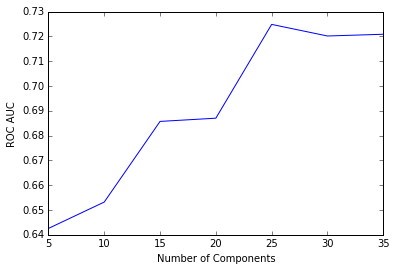

In [104]:
plt.plot(components, pca_auc_scores)
plt.xlabel("Number of Components")
plt.ylabel("ROC AUC")
plt.show()

As seen, with 25 components the model performs the best against the rest of component counts, but the AUC score does not siginficantly improve (~0.725).

### Feature Hashing for ID
This part will be maybe a little tricky here, because we need to map **ID** to hash and output a customed length vector which represents number of features. Smaller number of features is likely to cause hash collison, whereas too large will cause larger coefficient dimensions in linear learners (e.g., Logisitic Regression).

In [111]:
user_ctr = df_ctr.groupby('ID')['Action'].mean().to_dict()
len(user_ctr)

218686

In [71]:
df_ctr['CTR'] = df_ctr.groupby('ID')['Action'].transform('mean')
df_ctr.head()

,Unnamed: 0,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime,DateTime,Year,Month,DayWeek,DayPeriod,Weekend,CTR
0,1,AMsySZbNg8SBwPtj7IGHnip_8aY0,1508761859495365,0,Facebook,300x600,Carter's,Pink,0.171601,2017-10-23 12:30:59.495365,0,10,Monday,Afternoon,0,0.0
1,2,AMsySZZcUFNGOJs-lfC9j-ZDlV7Z,1502847469736117,0,Facebook,300x250,Burberry,Red,4.303945,2017-08-16 01:37:49.736117,0,8,Wednesday,Night,0,0.0
2,3,AMsySZYoK8_bD0hGv4zu0iRn1TFo,1514169431528120,0,Facebook,728x90,Disney,Yellow,0.868106,2017-12-25 02:37:11.528120,0,12,Monday,Night,0,0.0
3,4,AMsySZahxpwLOWnMJj6RGATgwEOc,1515527952591896,0,Facebook,320x50,Carter's,Yellow,0.802647,2018-01-09 19:59:12.591896,1,1,Tuesday,Evening,0,0.0
4,5,AMsySZbqgfMBDtAqZz1jVRaOmX00,1507514809374045,0,instagram.com,300x250,Gap,Gold,0.627148,2017-10-09 02:06:49.374045,0,10,Monday,Night,0,0.0


In [72]:
id_hasher = FeatureHasher(input_type='string')
X_id = id_hasher.fit_transform(df_ctr['ID'])
X_id.shape

(1000000, 1048576)

In [56]:
X_data_csr = csr_matrix(X_data)

In [57]:
X_data_csr.shape

(1000000, 39)

In [73]:
X_data_id = hstack([X_data_csr, X_id])
X_data_id.shape

(1000000, 1048615)

In [74]:
X_train_id, X_test_id, y_train, y_test = train_test_split(X_data_id, y_data,
                                                          test_size=0.1, random_state=13)

In [75]:
lr_model = LR(C=0.001, class_weight='balanced')

lr_model.fit(X_train_id, y_train)

y_pred_prob = lr_model.predict_proba(X_test_id)
roc_auc_score(y_test, y_pred_prob[:, 1])

0.6958231064736211

As seen, the ROC AUC score does not improve rather decrease. It is speculated that since we only have 211 users who have clicked the prior information does not make too much impact on the target, and rather the high sparsity degrades the LR performance. Although, this result should be cross-validated, due to the time constraint I will not proceed with it. 

### Insights on Oversampling
Throughout the entire analysis, I have not performed resampling on the dataset as the AUC score is considered acceptable. The nice little feature in the Sklearn's logistic regression (for Random Forest and etc.) is that you can specify the class weight that the classifier will penalize/adjust the weights of classes to the loss function at fit time.

However, the results using actual resampling might be completely different. There are a few underlying issues that make me opt into not resampling. For start, between undersampling and oversampling I will prefer oversampling because with undersampling you are potentially lose a lot of information from the data (as there is highly imbalanced case this issue will be magnified). With oversampling, SMOTE is one of the most popular techniques for data with low dimensionality (e.g., 2D). One of the limitations of SMOTE (imblearn) is that it only supprots continuous data (this still remains a open issue https://github.com/scikit-learn-contrib/imbalanced-learn/issues/401), but in our case we have mostly or exclusively categorical (non-continuous) data. In my function *cv_select_model* I provided an option to oversample the training set during cross validation, and a workround to convert the continuous resampled data to non-continous is to round the floats to integer but at a cost of losing some information (or become more noisy). This ultimately leads to another issue with oversampling that is the discrepancy of class distribution presented in training and validation/testing sets. The correct way to approach this is to tune a different decision threshold as opposed to the original decision boundary for binary classification which is 0.5. The perfect cutoff probability is usually to be found with cross validation on the entire set.

### Online Learning Algorithms
There are a few advanced online learning algorithms which have gained high popularity in CTR prediction community, such as the Follow-the-Regularized-Leader (FTRL) and Factorization Machine (FM). There are some very successful cases incorporating LR with FTRL algorithm that produces highly promising results with large dimensional space data (can go up to millions). The general idea is to apply hashing trick (i.e., feature hashing) that maps the high dimensional data into a smaller dimension space and work from there (http://www.eecs.tufts.edu/~dsculley/papers/ad-click-prediction.pdf).

### Xgboost
Boosting algorithm is actually a pretty good option (gradient boosting draw tie with logisitic regression in previous sections) for class imbalanced dataset, as it is trained with previous weak learner's residuals sequentially to reduce bias. XGBoost will be a great candidate due to its capability of parallism and engineered regularization method if we want to explore further beyond the logistic regression.